# Initialization

## Package installation

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive') #force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=b41eff26088f4612af3d4bd7c44934666735179a65f9a804e5373287df97e914
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:
!pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp36-none-any.whl size=6083 sha256=74a2fde65649650ce68fcbee4bb15d7fde87ad3b0a785a4eaa9d5712df9aae51
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [ ]:
!pip install nlpaug

     |████████████████████████████████| 389kB 10.7MB/s 


## Library import and variable definition

In [ ]:
# Import libraries
import os
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import keras
import tensorflow as tf
import IPython.display as ipd
import librosa
import python_speech_features as psf
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import shutil
from tqdm import tqdm

import ffmpeg
import nlpaug
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
import librosa
import librosa.display as librosa_display
import scipy.io.wavfile as wavf


from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


pd.set_option('display.max_colwidth', None)

In [ ]:
# Apply function to augmented data
directory = '/content/drive/My Drive/ZINDI/data_new_order/audio_train/'
paths = []

for subdir, dirs, files in os.walk(directory):
    for file in files:
        paths.append(str(subdir) + '/' + file)

len(paths)

4709

In [ ]:
# Define paths

train_path = '/content/drive/My Drive/ZINDI/data/spectrogram_train/'
test_path = '/content/drive/My Drive/ZINDI/data/spectrogram_test/'
base_path = '/content/drive/My Drive/ZINDI/'

img_height = 256
img_width = 256

In [ ]:
len(os.listdir('/content/drive/My Drive/ZINDI/data_new_order/spectrogram_test/'))
# len(os.listdir('/content/drive/My Drive/ZINDI/data_new_order/audio_test/'))

1017

# Creating augmented data

In [ ]:
# copy directory structure 

def ig_f(dir, files):
    return [f for f in files if os.path.isfile(os.path.join(dir, f))]

# shutil.copytree('audio_train/', 'spectrogram_augmented/', ignore=ig_f)

shutil.copytree('/content/drive/My Drive/ZINDI/data_new_order/audio_train/', '/content/drive/My Drive/ZINDI/data_new_order/audio_augmented/', ignore=ig_f)

In [ ]:
# Loop through audio file repo and apply augmentation to every file

directory = '/content/drive/My Drive/ZINDI/data_new_order/audio_train/'
paths = []

for subdir, dirs, files in os.walk(directory):
    for file in files:
        paths.append(str(subdir) + '/' + file)

len(paths)

23545

In [ ]:
sr=44100
# Funktion um audio Dateien zu augmentieren 
def aug_pitch(file_path, sr=44100, factor=(2,3)):
    data, sr = librosa.load(file_path, sr=sr)
    aug = naa.PitchAug(sampling_rate=sr, factor=factor)
    augmented_data = aug.augment(data)
    return(augmented_data)

def aug_noise(file_path, sr=44100):
    data, sr = librosa.load(file_path, sr=sr)
    aug = naa.NoiseAug(color='white', zone=(0.0, 1.0))
    augmented_data = aug.augment(data)
    return(augmented_data)

def aug_shift(file_path,sr=44100):
    data, sr = librosa.load(file_path, sr=sr)
    aug = naa.ShiftAug(sampling_rate=sr, duration=0.5, shift_direction='left')
    augmented_data = aug.augment(data)
    return(augmented_data)

def aug_speed(file_path,sr=44100):
    data, sr = librosa.load(file_path, sr=sr)
    aug = naa.SpeedAug(factor=(0.3,0.7),coverage=0.5)
    augmented_data = aug.augment(data)
    return(augmented_data)

In [ ]:
for path in tqdm(paths):
    for func in (aug_pitch, aug_noise, aug_shift, aug_speed):
        augmented_data = func(path)
        out = '{}_{}.wav'.format(path.split('.')[0], func.__name__)
        wavf.write(out, sr, augmented_data)

In [ ]:
paths[0].split('.')[0].replace('audio_train', 'audio_test')

'/content/drive/My Drive/ZINDI/data_new_order/audio_test/super grow/4LYSSGJ'

# Creating augmented spectrograms

In [ ]:
# Define the function

def im_from_audio(fn, sample_rate=44100, window_length=0.05, window_step=0.0045, NFFT=2205):
  
    # Load the audio into an array (signal) at the specified sample rate
    signal, sr = librosa.load(fn, sr=sample_rate)
  
    # preemphasis
    signal = psf.sigproc.preemphasis(signal, coeff=0.95)
  
    # get specrogram
    # Get the frames
    frames = psf.sigproc.framesig(signal, 
                                    window_length*sample_rate, 
                                    window_step*sample_rate, 
                                    lambda x:np.ones((x,)))        # Window function 
      
    # magnitude Spectrogram
    spectrogram = np.rot90(psf.sigproc.magspec(frames, NFFT))
    
    # get rid of high frequencies
    spectrogram = spectrogram[512:,:]
  
    # normalize in [0, 1]
    spectrogram -= spectrogram.min(axis=None)
    spectrogram /= spectrogram.max(axis=None)        
  
    # Clip to max 512, 512
    spectrogram = spectrogram[:512, :512]
    
    return spectrogram 


In [ ]:
# Apply function to augmented data
directory = '/content/drive/My Drive/ZINDI/data_new_order/testing_data/'
paths = []

for subdir, dirs, files in os.walk(directory):
    for file in files:
        paths.append(str(subdir) + '/' + file)

len(paths)

42

In [ ]:
# copy directory structure 

def ig_f(dir, files):
    return [f for f in files if os.path.isfile(os.path.join(dir, f))]

# shutil.copytree('audio_train/', 'spectrogram_augmented/', ignore=ig_f)

shutil.copytree('/content/drive/My Drive/ZINDI/data_new_order/audio_train/', '/content/drive/My Drive/ZINDI/data_new_order/audio_augmented/', ignore=ig_f)

'/content/drive/My Drive/ZINDI/data_new_order/audio_augmented/'

In [ ]:
for i in tqdm(paths):
    interim1 = i.replace('.wav', '')
#     interim2 = interim1.replace('audio_train', 'spectrogram_augmented')    
    interim2 = interim1.replace('/content/drive/My Drive/ZINDI/data_new_order/testing_data/', '/content/drive/My Drive/ZINDI/data_new_order/testing_spec/') 
    name = '{}-spectrogram.png'.format(interim2)
    plt.imsave(fname = name, arr = im_from_audio(i))

# Building a CNN model

## Loading and converting the data

In [ ]:
# Load labels for first and second wave of data
train = pd.read_csv('/content/drive/My Drive/ZINDI/train_full.csv')
# labels_new = pd.read_csv('/content/drive/My Drive/ZINDI/labels_new.csv')

In [ ]:
# Create a well formatted Dictionary from all data with a label
label_dict = {}
for index, row in train.iterrows():
    label_dict[(row['fn'].split('/')[1]).split('.')[0]] = row['label']

In [ ]:
len(label_dict)

4709

In [ ]:
# Check again naming convention of spectrograms
test = os.listdir(train_path)

sample_size = 10
sorted_sample = [test[i] for i in sorted(random.sample(range(len(test)), sample_size))]
sorted_sample

['d027264654b94950aeb204f64d05d8d7_0c179f76b1a44e1eaf6b59a89f939285-spectrogram.png',
 '6fbfcce2cf21419e97290f9e12934f65_19f2a95209f04af1a850729c702af855-spectrogram.png',
 '6fbfcce2cf21419e97290f9e12934f65_16a7c8842fed44db8b103f4babe1c78a-spectrogram.png',
 '6fbfcce2cf21419e97290f9e12934f65_7d2982d60fc14fce9204fe041bf02ff7-spectrogram.png',
 'd027264654b94950aeb204f64d05d8d7_761580572bdd48e6b4697c390bf6e961-spectrogram.png',
 '1b5a69c4b88b41eb9577a656e11bb7dd_e1f476dfed434740a54b19d43dc66b1d-spectrogram.png',
 '744b1a437234489fae9512694d2212ae_a330a84af8fb4d058918266c35912d39-spectrogram.png',
 '8CHV763-spectrogram.png',
 'J73WESQ-spectrogram.png',
 '3d43af6faf2244c288154dc4ff6a734f_1f5042e2cc414c8c91ef8bf53a5580fc-spectrogram.png']

In [ ]:
# array with order of files like in spectrogram folder
file_names = []
label_array = []
# loop over the input images
for imgname in os.listdir(train_path):
    # load the image, pre-process it, and store it in the data list
    file_names.append(imgname.split('-')[0])
    label_array.append(label_dict[imgname.split('-')[0]])

In [ ]:
# converting images into arrays
img_height = 256
img_width = 256
img_data = []
# loop over the input images
for imagePath in tqdm(os.listdir(train_path)):
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(train_path + imagePath)
    image = cv2.resize(image, (img_height, img_width))
    image = img_to_array(image, dtype=np.float16)
    img_data.append(image)

In [ ]:
len(os.listdir('/content/drive/My Drive/ZINDI/data/audio_train'))

4709

In [ ]:
# One Hot encode the integer encoded labels
ohe = OneHotEncoder(sparse=False)
label_array = np.array(label_array)
label_array = label_array.reshape(len(label_array), 1)
label_ohe = ohe.fit_transform(label_array)
print(label_ohe.shape)

(4709, 193)


In [ ]:
files_data = np.array(img_data)
print(files_data.shape)

# train test split of the files
train_files, test_files, train_labels, test_labels = train_test_split(files_data, label_ohe, random_state=42, test_size=0.2, stratify=label_ohe.argmax(axis=1))

(4709, 256, 256, 3)


In [ ]:
# label distribution in test set
test_labels.argmax(axis=1) # 222 test files equals to 20% of the data
unique, counts = np.unique(test_labels.argmax(axis=1), return_counts=True)
dict(zip(unique, counts))

## Define a CNN architecture

In [ ]:
#Define Model architecture
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(193, activation='softmax'))

#Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               1

## Model training

In [ ]:
# Automatically save the best model only
# Source: https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
checkpoint = ModelCheckpoint("/content/drive/My Drive/ZINDI/models/best_model.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

history = model.fit(train_files, train_labels, batch_size=4, epochs=20, verbose=1, validation_data=(test_files, test_labels), callbacks=[checkpoint])

# history = model.fit(train_files, train_labels, batch_size=4, epochs=20, verbose=1, validation_data=(test_files, test_labels))

## Training results

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

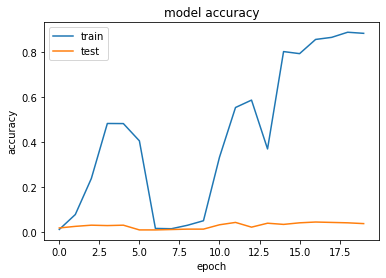

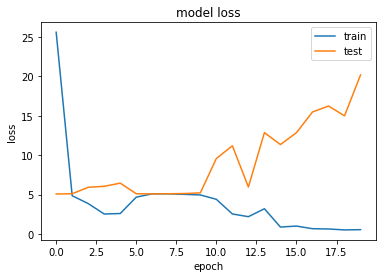

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Save the model
model_name = 'initial_model'

model.save('/content/drive/My Drive/ZINDI/models/' + model_name + '.h5')  # creates a HDF5 file 'my_model.h5'
# del model2  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('initial_model.h5')

## Submission

In [ ]:
test_file_names = []
# loop over the input images
for imgname in os.listdir('/content/drive/My Drive/ZINDI/spectogram-test/'):
    # load the image, pre-process it, and store it in the data list
    test_file_names.append(imgname.split('-')[0])

In [ ]:
# converting validation-images into arrays
img_height = 256
img_width = 256
test_img_data = []
# loop over the input images
for imagePath in tqdm(os.listdir('/content/drive/My Drive/ZINDI/spectogram-test/')):
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread('/content/drive/My Drive/ZINDI/spectogram-test/'+imagePath)
    image = cv2.resize(image, (img_height, img_width))
    image = img_to_array(image)
    test_img_data.append(image)

In [ ]:
test_img_data_array = np.array(test_img_data)

In [ ]:
label_array.shape

(2849, 1)

In [ ]:
samplesub = pd.read_csv('/content/drive/My Drive/data/SampleSubmission.csv')
samplesub.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,...,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_pred = model.predict(test_img_data_array)

In [ ]:
# Format label and file names right so they match the SampleSubmission DF
_, idx = np.unique(label_array_squeezed, return_index=True)
label_array_unique = label_array_squeezed[np.sort(idx)]

test_file_names_wav = []
for i in test_file_names:
  test_file_names_wav.append('audio_files/'+i+'.wav')

In [ ]:
first_submission = pd.DataFrame(data=y_pred, columns=label_array_unique) #

In [ ]:
first_submission.insert(loc=0, column='fn', value=test_file_names_wav)
first_submission.head()

,fn,ddagala,irrigate,ebigimusa,akasaanyi,ekikajjo,emmwanyi,ekiwojjolo,ebibala,weeding,orange,sikungula,ebyobulimi,ensuku,micungwa,farmer,muwogo,plant,spray,pepper,ekijanjaalo,obumonde,garden,okusaasaanya,abalimi,nnasale beedi,kaamulali,doodo,ebikolo,obusaanyi,enva endiirwa,nfukirira,omulimisa,endwadde,muceere,ejjobyo,ebikajjo,okulimibwa,enkota,nursery bed,...,obutunda,butterfly,rice,bibala,ebbugga,ppaapaali,okunnoga,obutungulu,medicine,lusuku,ennyaanya,insects,mango,eppapaali,omusiri,kikajjo,okukungula,Spinach,Pump,ebinyebwa,nnimiro,onion,maize stalk borer,ekibala,watermelon,maize streak virus,ekyeya,okulima,passion fruit,beans,disease,ekikoola,pawpaw,faamu,okukkoola,cabbages,eggobe,sugarcane,banana,ekikolo
0,audio_files/0MV7LQS.wav,9.444735e-24,9.032161e-38,4.549012e-21,8.000983e-08,1.987164e-29,1.532657e-16,4.125623e-26,2.817398e-08,1.192250e-18,2.295398e-17,8.460410e-20,3.107946e-15,5.397577e-20,9.177227e-24,5.159140e-18,6.778901e-17,0.000000e+00,9.579717e-24,6.212802e-15,4.238476e-15,1.879837e-30,6.528606e-34,2.174225e-33,2.170132e-25,1.636923e-30,7.342252e-31,3.778174e-29,1.225423e-16,4.959265e-25,2.675361e-27,1.169432e-16,8.114832e-24,6.906451e-20,5.697692e-21,4.112122e-13,6.227976e-19,1.105661e-06,1.497217e-15,9.128616e-26,...,1.130642e-22,1.118970e-24,9.990674e-01,1.727916e-12,3.384063e-20,4.318602e-12,2.837385e-22,6.124954e-16,9.732896e-13,1.072936e-14,3.458108e-20,2.510708e-14,1.631660e-17,6.453609e-25,6.751590e-34,1.773519e-37,4.064533e-16,0.000000e+00,1.394924e-33,9.530975e-33,7.579154e-04,2.977604e-16,1.118993e-21,1.924634e-32,2.973997e-29,4.737484e-36,4.954336e-15,5.225721e-37,0.000000e+00,1.109027e-37,3.675920e-18,1.775135e-31,1.560332e-37,1.103597e-26,4.219166e-38,7.442029e-28,1.571314e-25,0.000000e+00,2.872108e-25,6.925410e-38
1,audio_files/0L47WFH.wav,5.079751e-06,6.673069e-06,5.467417e-03,1.118456e-04,1.213590e-03,2.564944e-04,3.032071e-03,2.496147e-02,1.247088e-03,2.796572e-01,1.461458e-04,5.094288e-03,4.126826e-03,1.498035e-03,3.344400e-03,1.643791e-03,3.522796e-07,2.069343e-06,6.293617e-04,4.414560e-04,6.824473e-06,3.374861e-05,4.259539e-05,3.274433e-06,6.478956e-05,1.213985e-05,1.479869e-04,1.875540e-03,1.421207e-04,1.234293e-05,7.326836e-04,4.701525e-04,1.193252e-03,1.796845e-03,1.211571e-02,1.091075e-02,1.246665e-04,4.465725e-02,2.158897e-03,...,2.172001e-03,8.266019e-04,6.490964e-03,2.957299e-02,3.253800e-03,3.658514e-04,1.060806e-02,7.467349e-04,1.109535e-03,9.783972e-04,6.377831e-04,4.687669e-02,5.762239e-05,3.154596e-03,2.726718e-04,1.320982e-04,3.207800e-03,5.344540e-07,1.603617e-05,2.705517e-05,1.546426e-03,7.249897e-05,1.138869e-02,6.416981e-06,2.270902e-04,4.646338e-04,1.026596e-02,1.122986e-03,3.668998e-05,7.161230e-05,2.105622e-04,2.153121e-05,9.232890e-05,3.391918e-06,6.934577e-07,7.630516e-05,1.353078e-05,5.099324e-05,5.581711e-05,5.007330e-06
2,audio_files/0N7JNLT.wav,2.098820e-20,1.231374e-19,1.857637e-12,2.107219e-13,9.111287e-14,1.460032e-09,3.783415e-14,1.643645e-08,5.532963e-14,6.282140e-14,4.607375e-17,1.309946e-11,3.092039e-11,7.452147e-22,4.394473e-11,1.088536e-15,2.117069e-24,4.288858e-20,5.280075e-13,5.884295e-10,1.402572e-18,2.369790e-19,2.703921e-25,1.298167e-25,1.722164e-15,7.283143e-18,2.326419e-12,5.430482e-13,2.556985e-10,3.382436e-23,3.044169e-13,3.465785e-13,2.858877e-16,8.023227e-12,4.623263e-14,3.211101e-14,1.156736e-15,1.294215e-05,9.116846e-15,...,3.962695e-17,7.111863e-15,5.034462e-12,1.447316e-10,4.599868e-13,4.026403e-10,3.038250e-14,9.373068e-02,9.048102e-01,7.792117e-12,1.958551e-17,6.193665e-08,3.432248e-13,2.426992e-15,2.701543e-22,2.710279e-20,1.891118e-07,8.048625e-23,1.420690e-21,5.219397e-28,1.806965e-12,1.945033e-14,1.565731e-13,1.157151e-15,4.004450e-19,3.965090e-29,5.345926e-12,5.307684e-27,1.916389e-23,7.417440e-20,5.279452e-20,2.658648e-20,3.068074e-24,3.660957e-15,1.754284e-22,1.533650e-13,1.742231e-16,1.143261e-20,2.567999e-20,3.337663e-24
3,audio_files/0OTDVG8.wav,1.879790e-31,1.203771e-29,7.232094e-19,9.981795e-28,4.626679e-18,8.781736e-26,4.399481

In [ ]:
first_submission.to_csv('/content/drive/My Drive/data/submissions/first_submission.csv', index=False)

# Building a CNN model with DataGenerator 
To reduce RAM issues, a DataGenerator is recommended 
Inspiration: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
# Load train labels
train = pd.read_csv('/content/drive/My Drive/ZINDI/train_full.csv')

In [ ]:
train.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


## Data Generator by keras

In [ ]:
# see also: https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function
# generate train dataset from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/ZINDI/data_new_order/spectrogram_train/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
)

# generate validation dataset from directory
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/ZINDI/data_new_order/spectrogram_train/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
)

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

### Simple model architecture

In [ ]:
#Define Model architecture
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(193, activation='softmax'))

#Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               1

### Transfer Learning architecture with VGG16

In [ ]:
# Define Transfer Learning architecture
# Load VGG16
VGG16 = tf.keras.applications.VGG16(include_top = False, 
                                    weights = 'imagenet', 
                                    input_shape = (img_width, img_height, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
# Build classifier on top
model_transfer = Sequential()
model_transfer.add(VGG16)
model_transfer.add(Flatten()) 

# 1-layer MLP with Dropout, BN
model_transfer.add(Dropout(rate=0.1)) # Can try varying dropout rates
model_transfer.add(Dense(512, activation='relu'))
model_transfer.add(Dropout(rate=0.1)) # Can try varying dropout rates

model_transfer.add(Dense(193, activation='softmax'))
VGG16.trainable = False
print(model_transfer.summary())
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 193)               99009     
Total params: 31,591,425
Trainable params: 16,876,737
Non-trainable params: 14,714,688
___________________________________

### Trying different Transfer models

In [ ]:
# Load pre-trained InceptionV3 model 
InceptionV3 = tf.keras.applications.InceptionV3(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(img_width, img_height, 3),
                pooling=None,
                # classes=193,
                classifier_activation="softmax",
              )

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
InceptionV3.summary()

In [ ]:
# Build classifier on top
model_transfer = Sequential()
model_transfer.add(InceptionV3)
model_transfer.add(Flatten()) 

# 1-layer MLP with Dropout, BN
model_transfer.add(Dropout(rate=0.1)) # Can try varying dropout rates
model_transfer.add(Dense(512, activation='relu'))
model_transfer.add(Dropout(rate=0.1)) # Can try varying dropout rates

model_transfer.add(Dense(193, activation='softmax'))
InceptionV3.trainable = False
print(model_transfer.summary())
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 193)               99009     
Total params: 59,651,041
Trainable params: 37,848,257
Non-trainable params: 21,802,784
_________________________________

## Training the model

In [ ]:
# old approach
# model_transfer.fit(x=train_ds, validation_data=validation_ds, epochs=5, verbose=1) #, workers=4, use_multiprocessing=True)

# Automatically save the best model only
# Source: https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# Documentation https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpoint = ModelCheckpoint("/content/drive/My Drive/ZINDI/models/best_model.hdf5", 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_freq='epoch')

history = model_transfer.fit(x=train_ds, 
                             validation_data=validation_ds, 
                             epochs=80, 
                             verbose=1, 
                             callbacks=[checkpoint])

Epoch 1/80
118/118 [==============================] - ETA: 0s - loss: 33.5418 - acc: 0.0093 
Epoch 00001: val_loss improved from inf to 5.24648, saving model to /content/drive/My Drive/ZINDI/models/best_model.hdf5
118/118 [==============================] - 1652s 14s/step - loss: 33.5418 - acc: 0.0093 - val_loss: 5.2465 - val_acc: 0.0074
Epoch 2/80
118/118 [==============================] - ETA: 0s - loss: 5.3047 - acc: 0.0111
Epoch 00002: val_loss improved from 5.24648 to 5.22911, saving model to /content/drive/My Drive/ZINDI/models/best_model.hdf5
118/118 [==============================] - 56s 478ms/step - loss: 5.3047 - acc: 0.0111 - val_loss: 5.2291 - val_acc: 0.0074
Epoch 3/80
118/118 [==============================] - ETA: 0s - loss: 5.2155 - acc: 0.0111
Epoch 00003: val_loss improved from 5.22911 to 5.21351, saving model to /content/drive/My Drive/ZINDI/models/best_model.hdf5
118/118 [==============================] - 57s 479ms/step - loss: 5.2155 - acc: 0.0111 - val_loss: 5.2135

In [ ]:
# model.save('/content/drive/My Drive/ZINDI/models/model_with_dataloader.hdf5')

model = load_model('/content/drive/My Drive/ZINDI/models/best_model.hdf5')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks(np.arange(0, 20, step=2))
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks(np.arange(0, 20, step=2))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Create predictions from model

Predictions are submitted in a given format which is shown in the SampleSubmission.csv file. Therefore we are also arranging the test files (rows) sorted alphanumerically and take over the order of labels (columns)

In [ ]:
ss = pd.read_csv('/content/drive/My Drive/ZINDI/SampleSubmission.csv')
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,...,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create list of paths to test files
d = '/content/drive/My Drive/ZINDI/data_new_order/spectrogram_test/'
paths = []
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

# create arrays from test images
# sorted alphanumerically to have the same order as in the SampleSubmission
img_array = []
for p in tqdm(sorted(paths)):
  img = tf.keras.preprocessing.image.load_img(p, target_size=(256, 256))

  img = tf.keras.preprocessing.image.img_to_array(img)
  img_array.append(img)  
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [ ]:
img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
# type(img_array)
# len(img_array[0][0][0][0])
print(img_array.shape)
img_array = tf.squeeze(img_array)

(1, 1017, 256, 256, 3)


Since we give the model an array with the test data already ordered alphanumerically, we only need th match the columns afterwards

In [ ]:
# Predict class probability for test files
predictions = model.predict(x=img_array, batch_size=32, verbose=1)

32/32 [==============================] - 3s 101ms/step


In [ ]:
# get prediction classes in the order they occur in the directory. This is the order they were used to train the model (from the train data)
# the predictions (probabilities) use this order
test = []
for root, dirs, filenames in os.walk('/content/drive/My Drive/ZINDI/data_new_order/spectrogram_train/'):
    test.append(dirs)

pred_classes = test[0]

In [ ]:
# Save the predictions in the required format
for i, label in enumerate(pred_classes):
  ss[label] = [t[i] for t in predictions]
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,obuwuka,ebikoola,obulimi,ebisoolisooli,kaamulali,eddagala,beans,omuyembe,leaf,kisaanyi,leaves,butterfly,okuzifuuyira,micungwa,ppaapaali,emboga,kikolo,harvest,olusuku,coffee,super grow,rice,ensujju,okulima,worm,ebbugga,onion,ensigo,plantation,...,ejjobyo,omulimi,okusimba,sweet potatoes,okufuuyira,farming instructor,nnasale beedi,passion fruit,ekitooke,ebisaanyi,ekyeya,enva endiirwa,emisiri,emiyembe,amatooke,ebiwuka,farm,ebinyebwa,amappapaali,ebimera,kassooli,harvesting,emmwanyi,akamonde,obumonde,cabbages,akasaanyi,spread,ebirime,drought,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.006214,0.002382,0.001455,0.00554,0.001404,0.006572,0.00686,0.005501,0.005959,0.006664,0.001409,0.005088,0.001131,0.001394,0.001411,0.00737,0.006823,0.001405,0.005973,0.007114,0.002392,0.00754,0.0019,0.006225,0.002127,0.005062,0.001669,0.006663,0.007119,0.011464,0.001141,0.00619,0.006445,0.001441,0.006645,0.007565,0.005953,0.002152,0.009637,...,0.006426,0.007135,0.007115,0.007342,0.005752,0.006397,0.007069,0.002382,0.012146,0.001162,0.007091,0.01127,0.007359,0.00462,0.001143,0.006866,0.006428,0.00192,0.011184,0.006671,0.006148,0.007736,0.000824,0.00598,0.000822,0.006672,0.001894,0.001949,0.001402,0.006009,0.007122,0.006844,0.001418,0.005299,0.00738,0.005274,0.005948,0.010557,0.005958,0.006848
1,audio_files/00P0NMV.wav,0.006214,0.002382,0.001455,0.00554,0.001404,0.006572,0.00686,0.005501,0.005959,0.006664,0.001409,0.005088,0.001131,0.001394,0.001411,0.00737,0.006823,0.001405,0.005973,0.007114,0.002392,0.00754,0.0019,0.006225,0.002127,0.005062,0.001669,0.006663,0.007119,0.011464,0.001141,0.00619,0.006445,0.001441,0.006645,0.007565,0.005953,0.002152,0.009637,...,0.006426,0.007135,0.007115,0.007342,0.005752,0.006397,0.007069,0.002382,0.012146,0.001162,0.007091,0.01127,0.007359,0.00462,0.001143,0.006866,0.006428,0.00192,0.011184,0.006671,0.006148,0.007736,0.000824,0.00598,0.000822,0.006672,0.001894,0.001949,0.001402,0.006009,0.007122,0.006844,0.001418,0.005299,0.00738,0.005274,0.005948,0.010557,0.005958,0.006848
2,audio_files/01QEEZI.wav,0.006214,0.002382,0.001455,0.00554,0.001404,0.006572,0.00686,0.005501,0.005959,0.006664,0.001409,0.005088,0.001131,0.001394,0.001411,0.00737,0.006823,0.001405,0.005973,0.007114,0.002392,0.00754,0.0019,0.006225,0.002127,0.005062,0.001669,0.006663,0.007119,0.011464,0.001141,0.00619,0.006445,0.001441,0.006645,0.007565,0.005953,0.002152,0.009637,...,0.006426,0.007135,0.007115,0.007342,0.005752,0.006397,0.007069,0.002382,0.012146,0.001162,0.007091,0.01127,0.007359,0.00462,0.001143,0.006866,0.006428,0.00192,0.011184,0.006671,0.006148,0.007736,0.000824,0.00598,0.000822,0.006672,0.001894,0.001949,0.001402,0.006009,0.007122,0.006844,0.001418,0.005299,0.00738,0.005274,0.005948,0.010557,0.005958,0.006848
3,audio_files/037YAED.wav,0.006214,0.002382,0.001455,0.00554,0.001404,0.006572,0.00686,0.005501,0.005959,0.006664,0.001409,0.005088,0.001131,0.001394,0.001411,0.00737,0.006823,0.001405,0.005973,0.007114,0.002392,0.00754,0.0019,0.006225,0.002127,0.005062,0.001669,0.006663,0.007119,0.011464,0.001141,0.00619,0.006445,0.001441,0.006645,0.007565,0.005953,0.002152,0.009637,...,0.006426,0.007135,0.007115,0.007342,0.005752,0.006397,0.007069,0.002382,0.012146,0.001162,0.007091,0.01127,0.007359,0.00462,0.001143,0.006866,0.006428,0.00192,0.011184,0.006671,0.006148,0.007736,0.000824,0.00598,0.000822,0.006672,0.001894,0.001949,0.001402,0.006009,0.007122,0.006844,0.001418,0.005299,0.00738,0.005274,0.005948,0.010557,0.005958,0.006848
4,audio_files/0382N0Y.wav,0.006214,0.002382,0.001455,0.00554,0.001404,0.006572,0.00686,0.005501,0.005959,0.006664,0.001409,0.005088,0.001131,0.001394,0.001411,0.00737,0.006823,0.001405,0.005973,0.007114,0.002392,0.00754,0.0019,0.006225,0.002127,0.005062,0.001669,0.006663,0.007119,0.011464,0.001141,0.00619,0.006445,0.001441,0.006645,0.007565,0.005953,0.0

In [ ]:
# save Submission to file
ss.to_csv('/content/drive/My Drive/ZINDI/submissions/Vorführung_submission.csv', index=False)

# Appendix: Tests

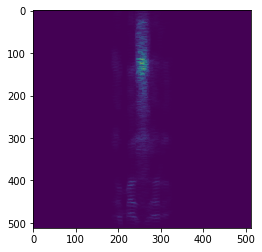

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/My Drive/data/spectrogram/1b5a69c4b88b41eb9577a656e11bb7dd_2e9c0177638541b2b296a5c67be23e73-spectogram.png')
plt.show()

In [ ]:
image = cv2.imread('/content/drive/My Drive/data/spectrogram/1b5a69c4b88b41eb9577a656e11bb7dd_2e9c0177638541b2b296a5c67be23e73-spectogram.png')
image_test = cv2.resize(image, (img_height, img_width))

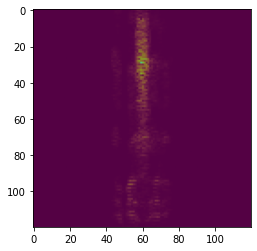

In [ ]:
from PIL import Image

# img = Image.fromarray(image_test, 'RGB')
# img.save('/content/drive/My Drive/my.png')
img = mpimg.imread('/content/drive/My Drive/my.png')
imgplot = plt.imshow(img)
plt.show()

Plot of data class distribution after train/test split

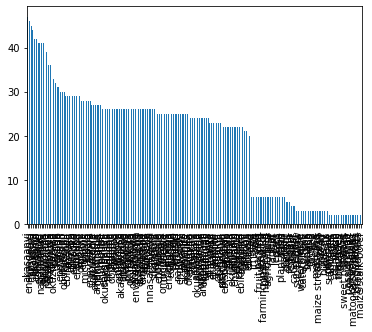

In [ ]:
train_labels.value_counts().plot(kind='bar')

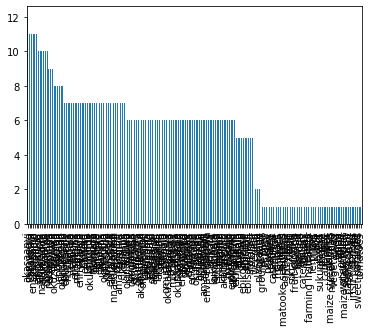

In [ ]:
test_labels.value_counts().plot(kind='bar')